In [24]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import KFold
import seaborn as sns

# Step 1: Data Preprocessing

In [13]:
# Define your target dataset path
target_dir = '../original_dataset'

# Check if the path exists
if os.path.exists(target_dir):
    print(f"The dataset path {target_dir} exists.")
else:
    print(f"The dataset path {target_dir} does not exist.")

The dataset path ../original_dataset exists.


## Check dataset size 

In [14]:
classes = ['home_office', 'hotel_room', 'church', 'museum', 'supermarket']

def show_target_dir_status(target_dir, classes):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Status of target directory: {target_dir}")
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class '{cls}' contains {num_images} images.")
            
        else:
            print(f"Class directory '{cls}' does not exist.")

# Show the status of the target directory
show_target_dir_status(target_dir, classes)

Status of target directory: ../original_dataset
Class 'home_office' contains 1346 images.
Class 'hotel_room' contains 1524 images.
Class 'church' contains 798 images.
Class 'museum' contains 761 images.
Class 'supermarket' contains 1466 images.


## Show images with their corresponded labels 

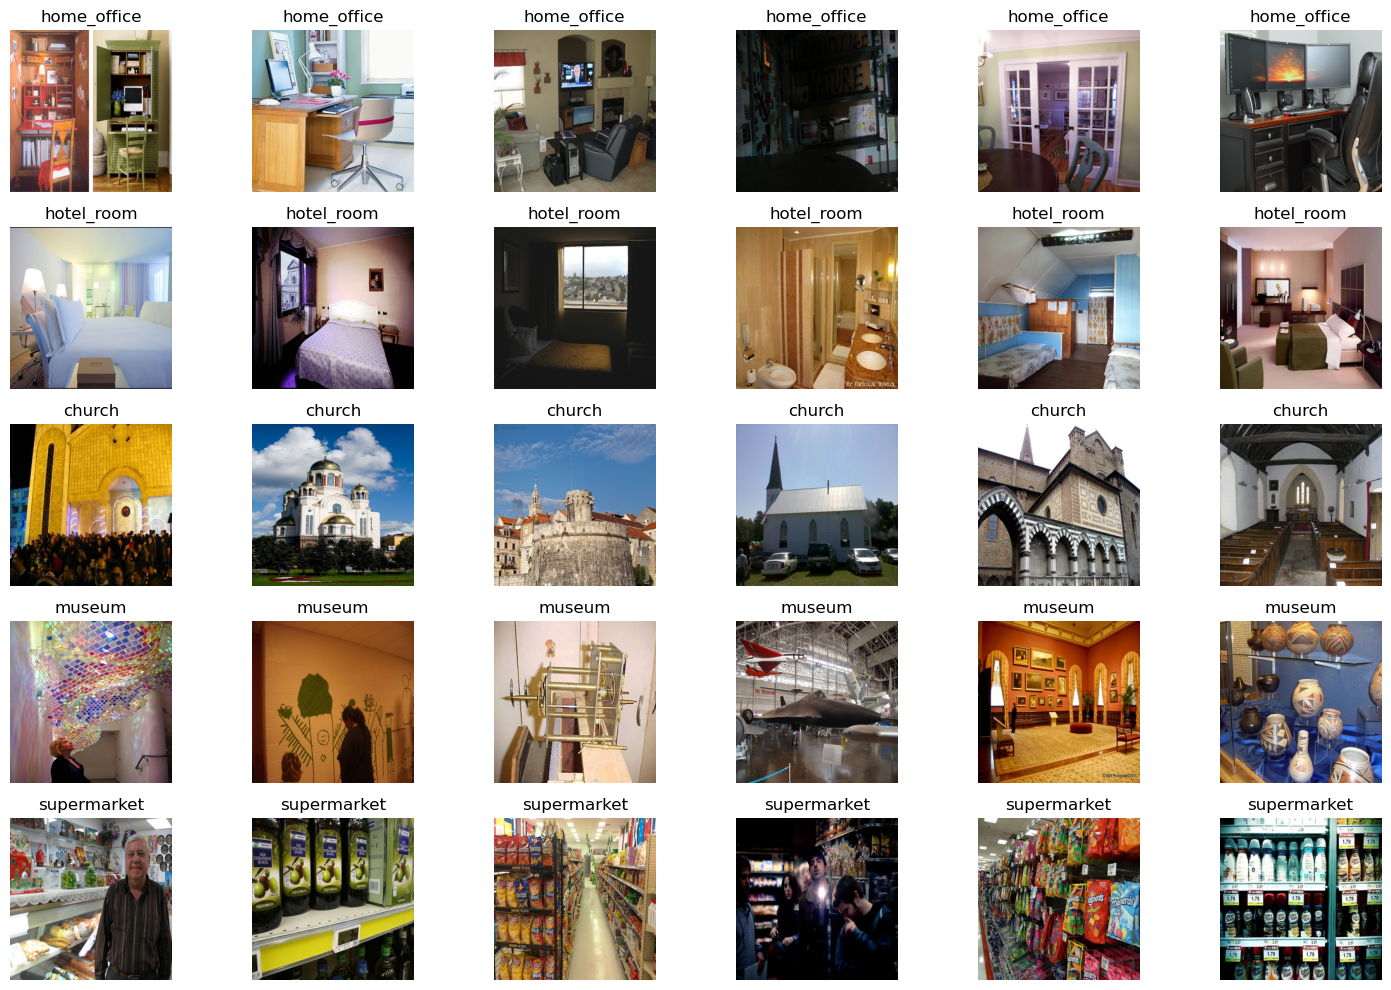

In [15]:
def show_images_with_labels(target_dir, classes, num_images=6):
    """
    Display images with their corresponding labels from the target directory.

    """
    # Create figure and axes
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 10))
    
    # Iterate through each class
    for i, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        class_images = os.listdir(class_dir)
        selected_images = np.random.choice(class_images, num_images, replace=False)
        
        # Iterate through selected images for the class
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            
            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')
    
    # Adjust layout and display the plot
    plt.tight_layout()

show_images_with_labels(target_dir, classes)

In [16]:
# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Parameters
batch_size = 64
image_size = (256, 256)
k_folds = 10

# Transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(root='../original_dataset', transform=train_transform)
dataset_size = len(dataset)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Define the CNN Model

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model and move it to the device
model = CNN().to(device)

# Step 3: Training the Model

## Setting hyperparameters and functions for training and validation

In [18]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 30

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Updated training and validation functions to store loss and accuracy
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy

## Set up k-fold cross-validation

In [19]:
# K-Fold Cross Validation
kf = KFold(n_splits=k_folds, shuffle=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(dataset_size))):
    print(f'Fold {fold + 1}/{k_folds}')

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss function, and optimizer
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    # Train and validate the model
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_accuracies.append(train_accuracy)
        fold_val_accuracies.append(val_accuracy)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')

    train_losses.append(fold_train_losses)
    val_losses.append(fold_val_losses)
    train_accuracies.append(fold_train_accuracies)
    val_accuracies.append(fold_val_accuracies)
    fold_results.append(best_accuracy)

# Print the results for each fold
print(f'K-Fold Cross Validation results for {k_folds} folds')
for i, acc in enumerate(fold_results):
    print(f'Fold {i + 1}: Best Validation Accuracy: {acc:.4f}')
print(f'Average Accuracy: {np.mean(fold_results):.4f}')

Fold 1/10
Epoch 1/20, Train Loss: 1.7703, Validation Loss: 1.1456, Train Accuracy: 36.60%, Validation Accuracy: 56.61%
Epoch 2/20, Train Loss: 1.1489, Validation Loss: 1.0151, Train Accuracy: 54.63%, Validation Accuracy: 61.36%
Epoch 3/20, Train Loss: 1.0677, Validation Loss: 0.9620, Train Accuracy: 58.78%, Validation Accuracy: 63.73%
Epoch 4/20, Train Loss: 1.0293, Validation Loss: 1.0051, Train Accuracy: 60.25%, Validation Accuracy: 60.34%
Epoch 5/20, Train Loss: 0.9933, Validation Loss: 0.9267, Train Accuracy: 61.81%, Validation Accuracy: 64.75%
Epoch 6/20, Train Loss: 0.9682, Validation Loss: 0.9147, Train Accuracy: 62.57%, Validation Accuracy: 65.08%
Epoch 7/20, Train Loss: 0.9206, Validation Loss: 0.8683, Train Accuracy: 64.98%, Validation Accuracy: 67.12%
Epoch 8/20, Train Loss: 0.9198, Validation Loss: 0.8453, Train Accuracy: 65.10%, Validation Accuracy: 68.31%
Epoch 9/20, Train Loss: 0.8804, Validation Loss: 0.9058, Train Accuracy: 65.83%, Validation Accuracy: 67.12%
Epoch 10/

Epoch 16/20, Train Loss: 0.7728, Validation Loss: 0.8509, Train Accuracy: 70.42%, Validation Accuracy: 66.72%
Epoch 17/20, Train Loss: 0.7533, Validation Loss: 0.8667, Train Accuracy: 71.55%, Validation Accuracy: 67.06%
Epoch 18/20, Train Loss: 0.7257, Validation Loss: 0.8512, Train Accuracy: 73.32%, Validation Accuracy: 66.38%
Epoch 19/20, Train Loss: 0.6989, Validation Loss: 0.7917, Train Accuracy: 73.40%, Validation Accuracy: 72.67%
Epoch 20/20, Train Loss: 0.6760, Validation Loss: 0.8989, Train Accuracy: 74.68%, Validation Accuracy: 64.86%
Fold 5/10
Epoch 1/20, Train Loss: 1.8000, Validation Loss: 1.3954, Train Accuracy: 35.26%, Validation Accuracy: 46.01%
Epoch 2/20, Train Loss: 1.2037, Validation Loss: 1.1433, Train Accuracy: 52.07%, Validation Accuracy: 55.52%
Epoch 3/20, Train Loss: 1.0821, Validation Loss: 1.0780, Train Accuracy: 57.99%, Validation Accuracy: 57.22%
Epoch 4/20, Train Loss: 1.0467, Validation Loss: 1.0141, Train Accuracy: 59.01%, Validation Accuracy: 61.12%
Epoc

Epoch 11/20, Train Loss: 0.8728, Validation Loss: 0.9322, Train Accuracy: 66.99%, Validation Accuracy: 66.55%
Epoch 12/20, Train Loss: 0.8340, Validation Loss: 0.9207, Train Accuracy: 68.08%, Validation Accuracy: 67.23%
Epoch 13/20, Train Loss: 0.8117, Validation Loss: 0.9081, Train Accuracy: 69.16%, Validation Accuracy: 65.70%
Epoch 14/20, Train Loss: 0.8344, Validation Loss: 0.9096, Train Accuracy: 67.59%, Validation Accuracy: 65.70%
Epoch 15/20, Train Loss: 0.7872, Validation Loss: 0.9093, Train Accuracy: 69.61%, Validation Accuracy: 66.04%
Epoch 16/20, Train Loss: 0.7632, Validation Loss: 0.8526, Train Accuracy: 70.14%, Validation Accuracy: 69.27%
Epoch 17/20, Train Loss: 0.7454, Validation Loss: 0.9008, Train Accuracy: 71.63%, Validation Accuracy: 67.74%
Epoch 18/20, Train Loss: 0.7501, Validation Loss: 0.8513, Train Accuracy: 71.55%, Validation Accuracy: 66.21%
Epoch 19/20, Train Loss: 0.7304, Validation Loss: 0.8551, Train Accuracy: 72.61%, Validation Accuracy: 67.91%
Epoch 20/2

# Step 4: Plotting the results

## Plotting train and validation loss

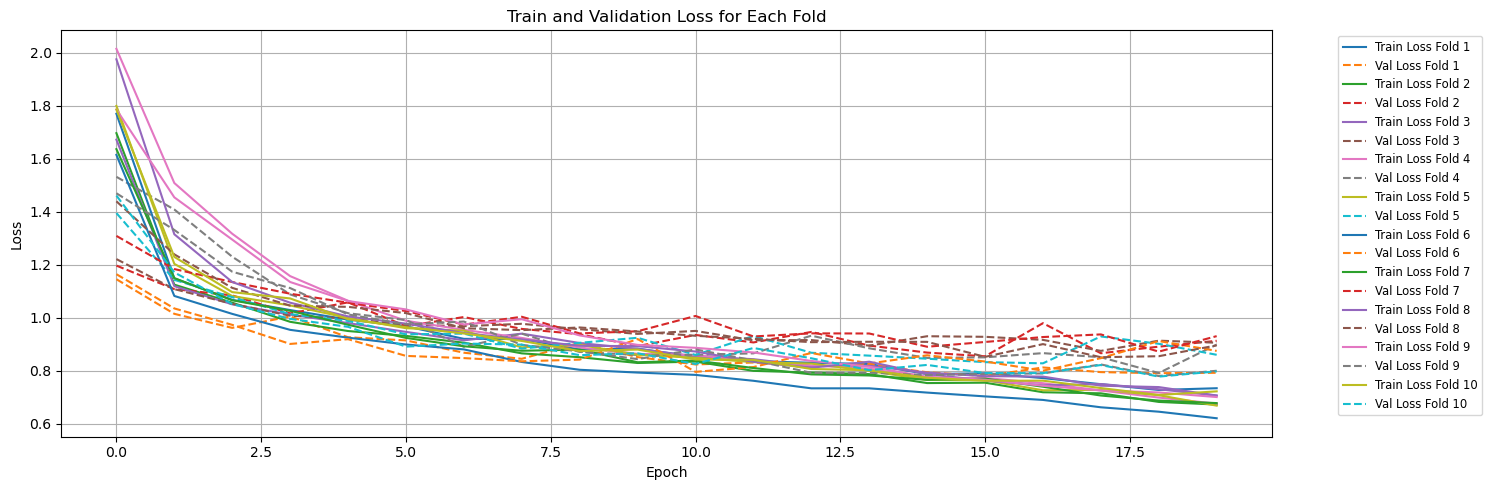

In [43]:
plt.figure(figsize=(15, 5))

for fold in range(k_folds):
    plt.plot(train_losses[fold], label=f'Train Loss Fold {fold+1}')
    plt.plot(val_losses[fold], label=f'Val Loss Fold {fold+1}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss for Each Fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()  # Adjust the plot to fit everything nicely
plt.show()

## Plotting train and validation accuracy

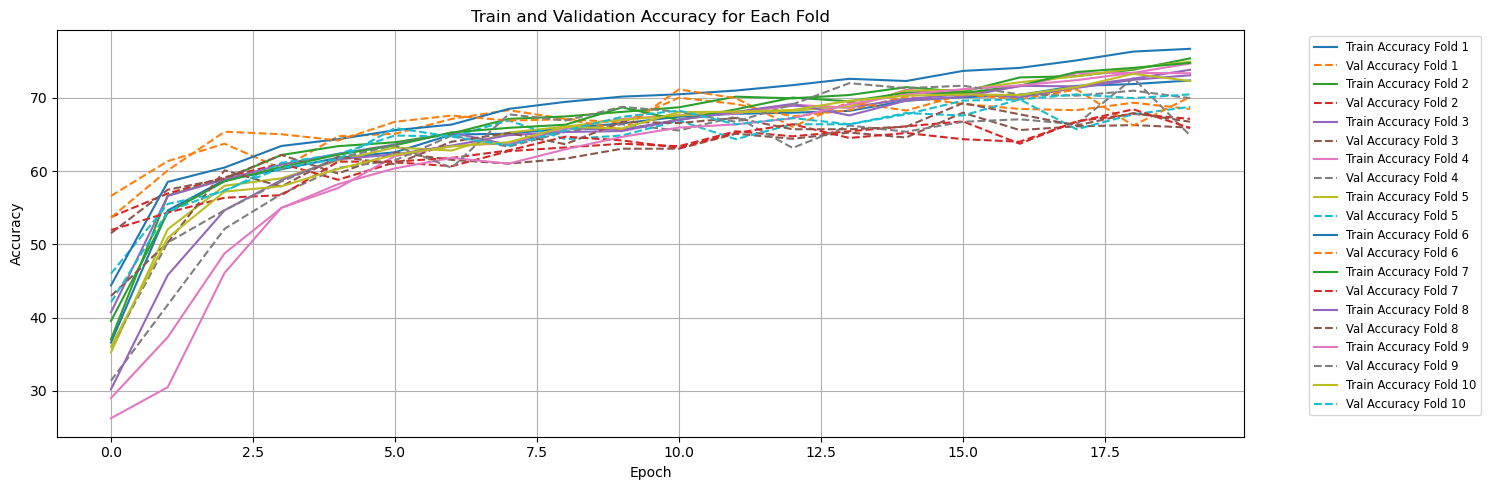

In [44]:
plt.figure(figsize=(15, 5))

for fold in range(k_folds):
    plt.plot(train_accuracies[fold], label=f'Train Accuracy Fold {fold+1}')
    plt.plot(val_accuracies[fold], label=f'Val Accuracy Fold {fold+1}', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy for Each Fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluating the best model and showing confusion matrix and metrics table

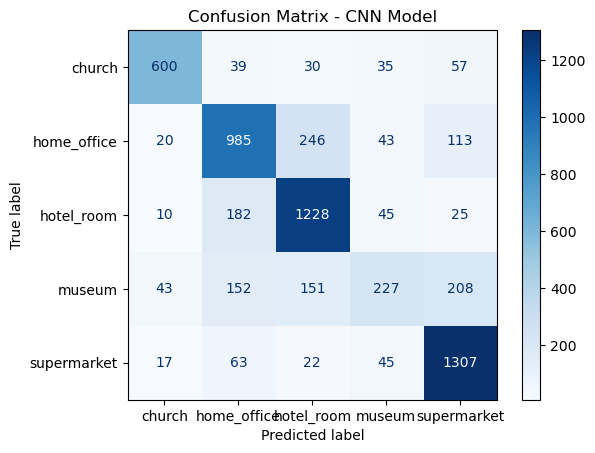

In [41]:
all_preds = []
all_labels = []

for fold in range(1, k_folds + 1):
    model = CNN().to(device)
    model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))

    kf = KFold(n_splits=k_folds, shuffle=True)
    for i, (train_idx, val_idx) in enumerate(kf.split(np.arange(dataset_size))):
        if i + 1 == fold:
            val_subset = Subset(dataset, val_idx)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
            break

    model.eval()
    fold_preds = []
    fold_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)
    
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN Model")
plt.show()

## Generating the report

In [42]:
# Classification Report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

Classification Report:
              precision    recall  f1-score   support

      church       0.87      0.79      0.83       761
 home_office       0.69      0.70      0.70      1407
  hotel_room       0.73      0.82      0.78      1490
      museum       0.57      0.29      0.39       781
 supermarket       0.76      0.90      0.83      1454

    accuracy                           0.74      5893
   macro avg       0.73      0.70      0.70      5893
weighted avg       0.73      0.74      0.72      5893

